In [5]:
import numpy as np
from scipy.stats import binom, poisson


def pa(params, model):
    n = params['amax'] - params['amin'] + 1
    return np.ones(n) / n, np.arange(params['amin'], params['amax'] + 1)


def pb(params, model):
    n = params['bmax'] - params['bmin'] + 1
    return np.ones(n) / n, np.arange(params['bmin'], params['bmax'] + 1)


def pc_ab(a, b, params, model):
    cmax = params['amax'] + params['bmax'] + 1
    vals = np.arange(cmax)
    p1, p2 = params['p1'], params['p2']

    if model == 1:
        a_probs = binom.pmf(np.arange(cmax), a.reshape(-1, 1), p1)
        b_probs = binom.pmf(np.arange(cmax), b.reshape(-1, 1), p2)
        probs = np.zeros((cmax, len(a), len(b)))
        for k in range(cmax):
            probs[k] = np.dot(a_probs[..., :k + 1], b_probs[..., :k + 1][..., ::-1].T)
        return probs, vals

    if model == 2:
        lambda_pois = p1 * a.reshape(-1, 1) + p2 * b
        probs = poisson.pmf(vals, np.expand_dims(lambda_pois, axis=2))[..., :cmax].transpose((2, 0, 1))
        return probs, vals


def pc(params, model):
    a = np.arange(params['amin'], params['amax'] + 1)
    b = np.arange(params['bmin'], params['bmax'] + 1)
    pc_ab_probs, _ = pc_ab(a, b, params, model)
    pc_ab_probs = pc_ab_probs 
    pc_probs = pc_ab_probs.sum(axis=(1, 2)).reshape(-1,) / len(b) / len(a)
    vals = np.arange(params['amax'] + params['bmax'] + 1)
    return pc_probs, vals


def pc_a(a, params, model):
    b = np.arange(params['bmin'], params['bmax'] + 1)
    pc_ab_probs, _ = pc_ab(a, b, params, model)
    pb_probs, _ = pb(params, model)
    pc_ab_probs = pc_ab_probs * pb_probs
    pc_probs = pc_ab_probs.sum(axis=2)
    vals = np.arange(params['amax'] + params['bmax'] + 1)
    return pc_probs, vals


def pc_b(b, params, model):
    a = np.arange(params['amin'], params['amax'] + 1)
    pc_ab_probs, _ = pc_ab(a, b, params, model)
    pa_probs, _ = pa(params, model)
    pc_ab_probs = pc_ab_probs * pa_probs.reshape(-1, 1)
    pc_probs = pc_ab_probs.sum(axis=1)
    vals = np.arange(params['amax'] + params['bmax'] + 1)
    return pc_probs, vals


def pd_c(c, params, model):
    dmax = 2 * (params['amax'] + params['bmax']) + 1
    vals = np.arange(dmax)
    c_probs, _ = pc(params, model)
    probs = binom.pmf(np.arange(dmax), c.reshape(-1, 1), params['p3'])
    rows, column_indices = np.ogrid[: probs.shape[0], : probs.shape[1]]
    column_indices = column_indices - c[:, np.newaxis]
    probs = probs[rows, column_indices]
    return probs.T, vals


def pd(params, model):
    c = np.arange(params['amax'] + params['bmax'] + 1)
    pd_c_probs, _ = pd_c(c, params, model)
    pc_probs, _ = pc(params, model)
    pd_c_probs = pd_c_probs * pc_probs.reshape(1, -1)
    pd_probs = pd_c_probs.sum(axis=1)
    vals = np.arange(2 * (params['amax'] + params['bmax']) + 1)
    return pd_probs, vals


def pc_d(d, params, model):
    vals = np.arange(params['amax'] + params['bmax'] + 1)

    pd_probs, _ = pd(params, model)
    pd_probs = pd_probs[d]
    pd_c_probs, _ = pd_c(vals, params, model)
    pd_c_probs = pd_c_probs[d]
    pc_probs, _ = pc(params, model)

    pc_d_probs = pd_c_probs * pc_probs.reshape(1, -1) / pd_probs.reshape(-1, 1)
    return pc_d_probs.T, vals


def pc_abd(a, b, d, params, model):
    vals = np.arange(params['amax'] + params['bmax'] + 1)

    pa_probs, vals_a = pa(params, model)
    pa_probs = pa_probs[:a.shape[0]]
    pb_probs, vals_b = pb(params, model)
    pb_probs = pb_probs[b.shape[0]]
    pd_c_probs, _ = pd_c(vals, params, model)
    pd_c_probs = pd_c_probs[d]
    pc_ab_probs, _ = pc_ab(a, b, params, model)

    probs = np.ones((params['amax'] + params['bmax'] + 1, a.shape[0], b.shape[0], d.shape[0]))
    probs *= pc_ab_probs[..., np.newaxis] * np.expand_dims(pd_c_probs.T, axis=(1, 2))
    probs *= pa_probs.reshape(1, -1, 1, 1) * pb_probs.reshape(1, 1, -1, 1)
    probs /= probs.sum(axis=0)
    return probs, vals

In [2]:
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'svg'

In [6]:
params = {'amin': 75, 'amax': 90, 'bmin': 500, 'bmax': 600,
              'p1': 0.1, 'p2': 0.01, 'p3': 0.3}

In [7]:
a_expected = np.array([83])
b_expected = np.array([(params['bmin'] + params['bmax']) // 2])
a_ = (params['amin'] + params['amax']) / 2
b_ = (params['bmin'] + params['bmax']) / 2
c_expected = (a_*params['p1'] + b_*params['p2'])
c_expected, c_expected*(1 + params['p3'])

(13.75, 17.875)

In [8]:
d_expected = np.array([18])

In [9]:
def plot_probs(vals, probs, labels, title, ylabel='Probability'):
    plt.figure(figsize=(7, 5))
    for val, prob, label in zip(vals, probs, labels):
        plt.plot(val, prob, label=label)
    plt.title(title, fontsize=12)
    plt.xlabel('Values', fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.legend()
    plt.grid('True')

In [ ]:
0.1*0.9*82.5 + 0.01*0.99*550 +0.1**2 * (16**2 - 1)/12 + 0.01**2 * (101**2 - 1)/12

13.167500000000002

In [ ]:
0.1*82.5 + 0.01*550 +0.1**2 * (16**2 - 1)/12 + 0.01**2 * (101**2 - 1)/12

14.047500000000001

In [ ]:
%%time
c_probs_1, c_vals_1 = pc(params, model=1)

CPU times: user 278 ms, sys: 121 ms, total: 399 ms
Wall time: 237 ms


In [ ]:
%time
c_probs_2, c_vals_2 = pc(params, model=2)

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 6.2 µs


Model 1: Ec =  13.749999999999993
Model 2: Ec =  13.749999999999996
Model 1: Dc =  13.167500000000132
Model 2: Dc =  14.047500000000014


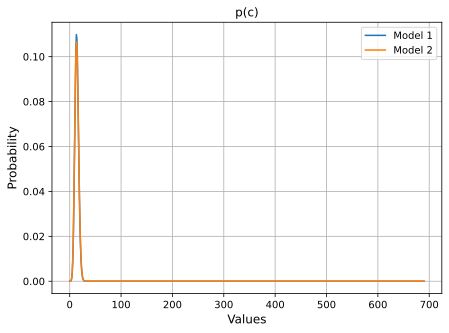

In [ ]:
print('Model 1: Ec = ', (c_probs_1 * c_vals_1).sum())
print('Model 2: Ec = ', (c_probs_2 * c_vals_2).sum())
print('Model 1: Dc = ', (c_probs_1 * c_vals_1**2).sum() - (c_probs_1 * c_vals_1).sum()**2)
print('Model 2: Dc = ', (c_probs_2 * c_vals_2**2).sum() - (c_probs_2 * c_vals_2).sum()**2)
plot_probs([c_vals_1, c_vals_2], [c_probs_1, c_probs_2], ['Model 1', 'Model 2'], 'p(c)')
plt.savefig('pc.pdf')

In [ ]:
%%time
pc_a_probs_1, c_vals_1 = pc_a(a_expected, params, model=1)

CPU times: user 119 ms, sys: 58.7 ms, total: 178 ms
Wall time: 117 ms


In [ ]:
%time
pc_a_probs_2, c_vals_2 = pc_a(a_expected, params, model=2)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 9.3 µs


Model 1: E(c|a) =  13.79999999999999
Model 2: E(c|a) =  13.79999999999999
Model 1: D(c|a) =  13.00000000000017
Model 2: D(c|a) =  13.885000000000105


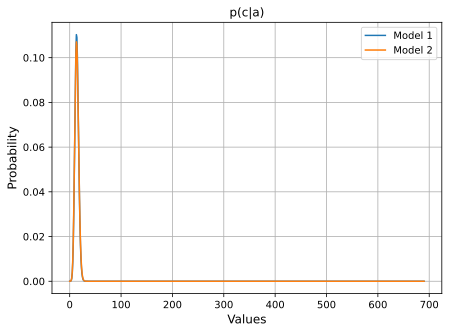

In [ ]:
print('Model 1: E(c|a) = ', (pc_a_probs_1.reshape(-1) * c_vals_1).sum())
print('Model 2: E(c|a) = ', (pc_a_probs_2.reshape(-1) * c_vals_2).sum())
print('Model 1: D(c|a) = ', (pc_a_probs_1.reshape(-1) * c_vals_1**2).sum() - (pc_a_probs_1.reshape(-1) * c_vals_1).sum()**2)
print('Model 2: D(c|a) = ', (pc_a_probs_2.reshape(-1) * c_vals_2**2).sum() - (pc_a_probs_2.reshape(-1) * c_vals_2).sum()**2)
plot_probs(c_vals_1, [pc_a_probs_1, pc_a_probs_2], ['Model 1', 'Model 2'], 'p(c|a)')
plt.savefig('pc_a.pdf')

In [ ]:
%%time
pc_b_probs_1, c_vals_1 = pc_b(b_expected, params, model=1)

CPU times: user 12.5 ms, sys: 871 µs, total: 13.3 ms
Wall time: 11.9 ms


In [ ]:
%%time
pc_b_probs_2, c_vals_2 = pc_b(b_expected, params, model=2)

CPU times: user 1.88 ms, sys: 0 ns, total: 1.88 ms
Wall time: 4 ms


Model 1: E(c|b) =  13.749999999999998
Model 2: E(c|b) =  13.749999999999986
Model 1: D(c|b) =  13.082500000000039
Model 2: D(c|b) =  13.962500000000148


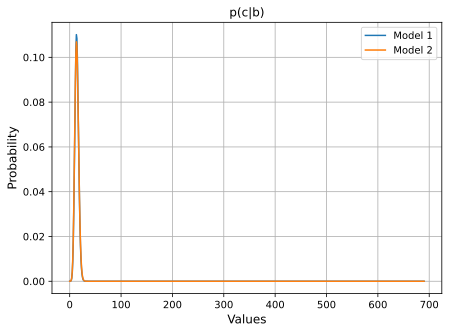

In [ ]:
print('Model 1: E(c|b) = ', (pc_b_probs_1.reshape(-1) * c_vals_1).sum())
print('Model 2: E(c|b) = ', (pc_b_probs_2.reshape(-1) * c_vals_2).sum())
print('Model 1: D(c|b) = ', (pc_b_probs_1.reshape(-1) * c_vals_1**2).sum() - (pc_b_probs_1.reshape(-1) * c_vals_1).sum()**2)
print('Model 2: D(c|b) = ', (pc_b_probs_2.reshape(-1) * c_vals_2**2).sum() - (pc_b_probs_2.reshape(-1) * c_vals_2).sum()**2)
plot_probs(c_vals_1, [pc_b_probs_1, pc_b_probs_2], ['Model 1', 'Model 2'], 'p(c|b)')
plt.savefig('pc_b.pdf')

In [ ]:
%%time
pc_ab_probs_1, c_vals_1 = pc_ab(a_expected, b_expected, params, model=1)

CPU times: user 7.4 ms, sys: 30 µs, total: 7.43 ms
Wall time: 15.4 ms


In [ ]:
%%time
pc_ab_probs_2, c_vals_2 = pc_ab(a_expected, b_expected, params, model=2)

CPU times: user 2.01 ms, sys: 0 ns, total: 2.01 ms
Wall time: 2.03 ms


Model 1: E(c|a, b) =  13.799999999999994
Model 2: E(c|a, b) =  13.800000000000011
Model 1: D(c|a, b) =  12.915000000000134
Model 2: D(c|a, b) =  13.799999999999926


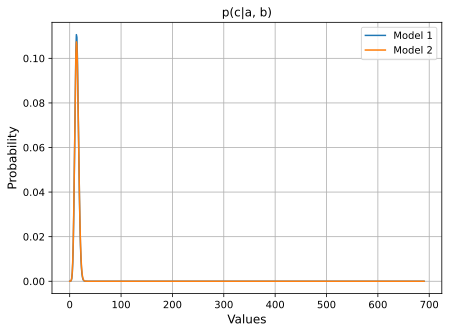

In [ ]:
print('Model 1: E(c|a, b) = ', (pc_ab_probs_1.reshape(-1) * c_vals_1).sum())
print('Model 2: E(c|a, b) = ', (pc_ab_probs_2.reshape(-1) * c_vals_2).sum())
print('Model 1: D(c|a, b) = ', (pc_ab_probs_1.reshape(-1) * c_vals_1**2).sum() - (pc_ab_probs_1.reshape(-1) * c_vals_1).sum()**2)
print('Model 2: D(c|a, b) = ', (pc_ab_probs_2.reshape(-1) * c_vals_2**2).sum() - (pc_ab_probs_2.reshape(-1) * c_vals_2).sum()**2)
plot_probs(c_vals_1, [pc_ab_probs_1.reshape(-1), pc_ab_probs_2.reshape(-1)], ['Model 1', 'Model 2'], 'p(c|a, b)')
plt.savefig('pc_ab.pdf')

In [14]:
%%time
pc_d_probs_1, c_vals_1 = pc_d(d_expected, params, model=1)

CPU times: user 1.4 s, sys: 807 ms, total: 2.2 s
Wall time: 1.3 s


In [ ]:
%%time
pc_d_probs_2, c_vals_2 = pc_d(d_expected, params, model=2)

CPU times: user 681 ms, sys: 96.5 ms, total: 778 ms
Wall time: 685 ms


Model 1: E(c|d) =  13.89597059898892
Model 2: E(c|d) =  13.893833892236298
Model 1: D(c|d) =  1.533581700672812
Model 2: D(c|d) =  1.5439433290956686


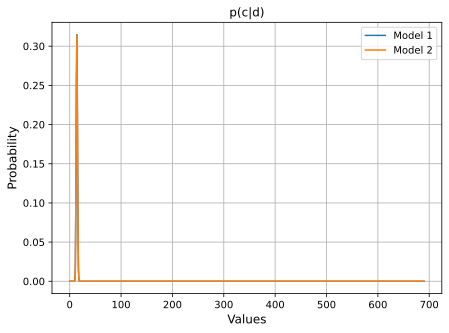

In [ ]:
print('Model 1: E(c|d) = ', (pc_d_probs_1.reshape(-1) * c_vals_1).sum())
print('Model 2: E(c|d) = ', (pc_d_probs_2.reshape(-1) * c_vals_2).sum())
print('Model 1: D(c|d) = ', (pc_d_probs_1.reshape(-1) * c_vals_1**2).sum() - (pc_d_probs_1.reshape(-1) * c_vals_1).sum()**2)
print('Model 2: D(c|d) = ', (pc_d_probs_2.reshape(-1) * c_vals_2**2).sum() - (pc_d_probs_2.reshape(-1) * c_vals_2).sum()**2)
plot_probs(c_vals_1, [pc_d_probs_1.reshape(-1), pc_d_probs_2.reshape(-1)], ['Model 1', 'Model 2'], 'p(c|d)')
plt.savefig('pc_d.pdf')

In [ ]:
%%time
pc_abd_probs_1, c_vals_1 = pc_abd(a_expected, b_expected, d_expected, params, model=1)

CPU times: user 449 ms, sys: 230 ms, total: 679 ms
Wall time: 423 ms


In [ ]:
%%time
pc_abd_probs_2, c_vals_2 = pc_abd(a_expected, b_expected, d_expected, params, model=2)

CPU times: user 247 ms, sys: 3.54 ms, total: 251 ms
Wall time: 253 ms


Model 1: E(c|a, b, d) =  13.902755594358693
Model 2: E(c|a, b, d) =  13.900175167039475
Model 1: D(c|a, b, d) =  1.5301402085200948
Model 1: D(c|a, b, d) =  1.5408838495819168


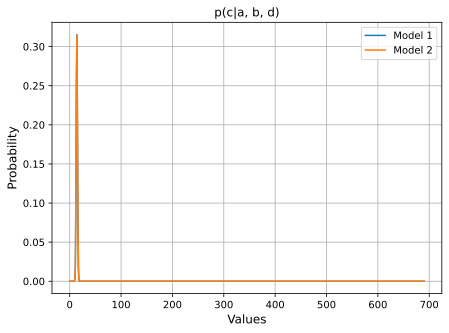

In [ ]:
print('Model 1: E(c|a, b, d) = ', (pc_abd_probs_1.reshape(-1) * c_vals_1).sum())
print('Model 2: E(c|a, b, d) = ', (pc_abd_probs_2.reshape(-1) * c_vals_2).sum())
print('Model 1: D(c|a, b, d) = ', (pc_abd_probs_1.reshape(-1) * c_vals_1**2).sum() - (pc_abd_probs_1.reshape(-1) * c_vals_1).sum()**2)
print('Model 1: D(c|a, b, d) = ', (pc_abd_probs_2.reshape(-1) * c_vals_2**2).sum() - (pc_abd_probs_2.reshape(-1) * c_vals_2).sum()**2)
plot_probs(c_vals_1, [pc_abd_probs_1.reshape(-1), pc_abd_probs_2.reshape(-1)], ['Model 1', 'Model 2'], 'p(c|a, b, d)')
plt.savefig('pc_abd.pdf')

In [16]:
%%time
pd_probs_1, c_vals_1 = pd(params, model=1)

CPU times: user 704 ms, sys: 318 ms, total: 1.02 s
Wall time: 622 ms


In [17]:
%%time
pd_probs_2, c_vals_2 = pd(params, model=2)

CPU times: user 328 ms, sys: 2.27 ms, total: 331 ms
Wall time: 333 ms


In [20]:
print('Model 1: E(d) = ', (pd_probs_1.reshape(-1) * c_vals_1).sum())
print('Model 2: E(d) = ', (pd_probs_2.reshape(-1) * c_vals_1).sum())
print('Model 1: D(d) = ', (pd_probs_1.reshape(-1) * c_vals_1**2).sum() - (pd_probs_1.reshape(-1) * c_vals_1).sum()**2)
print('Model 2: D(d) = ', (pd_probs_2.reshape(-1) * c_vals_1**2).sum() - (pd_probs_2.reshape(-1) * c_vals_1).sum()**2)

Model 1: E(d) =  17.874999999999986
Model 2: E(d) =  17.874999999999993
Model 1: D(d) =  25.140575000000354
Model 2: D(d) =  26.627774999999986


In [ ]:
p1_1, p1_2 = params['p1']*(1-params['p1']), params['p1']
p2_1, p2_2 = params['p2']*(1-params['p2']), params['p2']

In [ ]:
a_mean = (params['amax'] + params['amin']) / 2
b_mean = (params['bmax'] + params['bmin']) / 2

a_std =  ((params['amax'] - params['amin'] + 1)**2 - 1) / 12
b_std =  ((params['bmax'] - params['bmin'] + 1)**2 - 1) / 12

a_mean, a_std, b_mean, b_std

(82.5, 21.25, 550.0, 850.0)

In [ ]:
const_1 = p1_1*a_mean - p2_1*b_mean - p2_1**2 *b_std + p1_1**2 *a_std
const_2 = p1_2*a_mean - p2_2*b_mean - p2_2**2 *b_std + p1_2**2 *a_std
const_1, const_2

(2.0688165000000005, 2.8775)

In [ ]:
a = np.arange(params['amin'], params['amax'] + 1)
b = np.arange(params['bmin'], params['bmax'] + 1)
d = np.arange(2*(params['bmax'] + params['amax']) + 1)
a, b, d

(array([75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90]),
 array([500, 501, 502, 503, 504, 505, 506, 507, 508, 509, 510, 511, 512,
        513, 514, 515, 516, 517, 518, 519, 520, 521, 522, 523, 524, 525,
        526, 527, 528, 529, 530, 531, 532, 533, 534, 535, 536, 537, 538,
        539, 540, 541, 542, 543, 544, 545, 546, 547, 548, 549, 550, 551,
        552, 553, 554, 555, 556, 557, 558, 559, 560, 561, 562, 563, 564,
        565, 566, 567, 568, 569, 570, 571, 572, 573, 574, 575, 576, 577,
        578, 579, 580, 581, 582, 583, 584, 585, 586, 587, 588, 589, 590,
        591, 592, 593, 594, 595, 596, 597, 598, 599, 600]),
 array([   0,    1,    2, ..., 1378, 1379, 1380]))

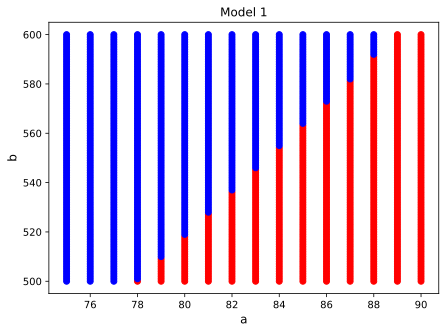

In [ ]:
plt.figure(figsize=(7, 5))
for a_val in a:
  for b_val in b:
    if p1_1*a_val - p2_1*b_val > const_1:
      plt.plot(a_val, b_val,'ro')
    else:
      plt.plot(a_val, b_val,'bo')
plt.title('Model 1', fontsize=12)
plt.xlabel('a', fontsize=12)
plt.ylabel('b', fontsize=12)
plt.savefig('da_db_1.pdf')

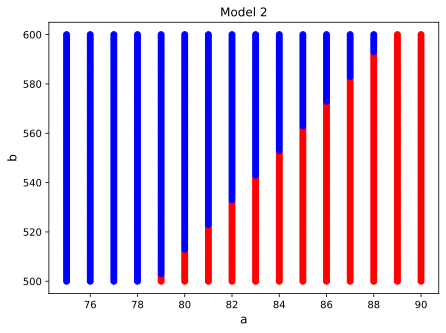

In [ ]:
plt.figure(figsize=(7, 5))
for a_val in a:
  for b_val in b:
    if p1_2*a_val - p2_2*b_val > const_2:
      plt.plot(a_val, b_val, 'ro')
    else:
      plt.plot(a_val, b_val, 'bo')
plt.title('Model 2', fontsize=12)
plt.xlabel('a', fontsize=12)
plt.ylabel('b', fontsize=12)
plt.savefig('da_db_2.pdf')

In [ ]:
pc_d_probs_1, c_vals_1 = pc_d(d, params, model=1)
pc_d_probs_2, c_vals_2 = pc_d(d, params, model=2)

pc_a_probs_1, c_vals_1 = pc_a(a, params, model=1)
pc_a_probs_2, c_vals_2 = pc_a(a, params, model=2)

pc_b_probs_1, c_vals_1 = pc_b(b, params, model=1)
pc_b_probs_2, c_vals_2 = pc_b(b, params, model=2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:94: RuntimeWarning: invalid value encountered in true_divide


In [ ]:
pc_a_std_1 = (pc_a_probs_1 * c_vals_1.reshape(-1, 1)**2).sum(axis=0) - (pc_a_probs_1 * c_vals_1.reshape(-1, 1)).sum(axis=0)**2
pc_b_std_1 = (pc_b_probs_1 * c_vals_1.reshape(-1, 1)**2).sum(axis=0) - (pc_b_probs_1 * c_vals_1.reshape(-1, 1)).sum(axis=0)**2
pc_d_std_1 = (pc_d_probs_1 * c_vals_1.reshape(-1, 1)**2).sum(axis=0) - (pc_d_probs_1 * c_vals_1.reshape(-1, 1)).sum(axis=0)**2

In [ ]:
pc_a_std_2 = (pc_a_probs_2 * c_vals_2.reshape(-1, 1)**2).sum(axis=0) - (pc_a_probs_2 * c_vals_2.reshape(-1, 1)).sum(axis=0)**2
pc_b_std_2 = (pc_b_probs_2 * c_vals_2.reshape(-1, 1)**2).sum(axis=0) - (pc_b_probs_2 * c_vals_2.reshape(-1, 1)).sum(axis=0)**2
pc_d_std_2 = (pc_d_probs_2 * c_vals_2.reshape(-1, 1)**2).sum(axis=0) - (pc_d_probs_2 * c_vals_2.reshape(-1, 1)).sum(axis=0)**2

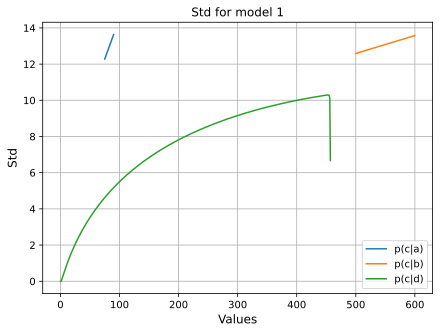

In [ ]:
plot_probs([a, b, d], [pc_a_std_1, pc_b_std_1, pc_d_std_1], ['p(c|a)', 'p(c|b)', 'p(c|d)'], 'Std for model 1', ylabel='Std')
plt.savefig('std_1.pdf')

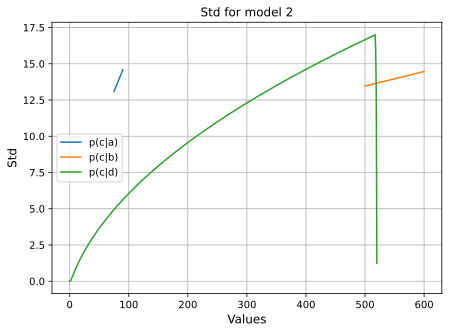

In [ ]:
plot_probs([a, b, d], [pc_a_std_2, pc_b_std_2, pc_d_std_2], ['p(c|a)', 'p(c|b)', 'p(c|d)'], 'Std for model 2', ylabel = 'Std')
plt.savefig('std_2.pdf')

In [ ]:
params = {'amin': 15, 'amax': 25, 'bmin': 1, 'bmax': 10,
              'p1': 0.95, 'p2': 0.8, 'p3': 0.3}

Model 1: Ec =  23.4
Model 2: Ec =  22.19851170680507
Model 1: Dc =  16.134999999999877
Model 2: Dc =  46.300797464809875


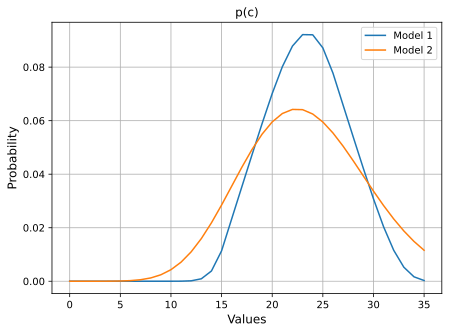

In [ ]:
c_probs_1, c_vals_1 = pc(params, model=1)
c_probs_2, c_vals_2 = pc(params, model=2)

print('Model 1: Ec = ', (c_probs_1 * c_vals_1).sum())
print('Model 2: Ec = ', (c_probs_2 * c_vals_2).sum())
print('Model 1: Dc = ', (c_probs_1 * c_vals_1**2).sum() - (c_probs_1 * c_vals_1).sum()**2)
print('Model 2: Dc = ', (c_probs_2 * c_vals_2**2).sum() - (c_probs_2 * c_vals_2).sum()**2)
plot_probs([c_vals_1, c_vals_2], [c_probs_1, c_probs_2], ['Model 1', 'Model 2'], 'p(c)')
plt.savefig('pc_new.pdf')